# Lopsided Ratings: An Analysis of Yelp Reviews##

Source: Yelp Dataset Challenge

In [1]:
source("RStart.R")

options(repr.plot.mimetypes = 'image/png', repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)

options(jupyter.plot_mimetypes = 'image/png')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
: package ‘ggplot2’ was built under R version 3.2.3Registering fonts with R

Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



# Processing the Data

In [2]:
review_df <- read_csv("yelp/yelp_academic_dataset_review.csv")

In [3]:
names(review_df)

[1] "user_id"      "review_id"    "text"         "votes.cool"   "business_id" 
 [6] "votes.funny"  "stars"        "date"         "type"         "votes.useful"

In [4]:
nrow(review_df)

[1] 1569264

First, let's focus on the ratings rather than the reviews

In [5]:
columns <- c("stars", "date")

ratings_df <- review_df %>%
        select(which(names(review_df) %in% columns))

head(ratings_df)

,stars,date
1,5,2007-05-17
2,2,2010-03-22
3,4,2012-02-14
4,4,2012-03-02
5,4,2012-05-15
6,1,2013-04-19


# Yelp Ratings over Time

In [6]:
ratings_daily <- ratings_df %>%
    group_by(date) %>%
    summarize(count = n()) %>%
    arrange(date)

head(ratings_daily)

,date,count
1,2004-10-12,2
2,2004-10-18,1
3,2004-10-19,6
4,2004-10-24,1
5,2004-10-26,1
6,2004-12-19,2


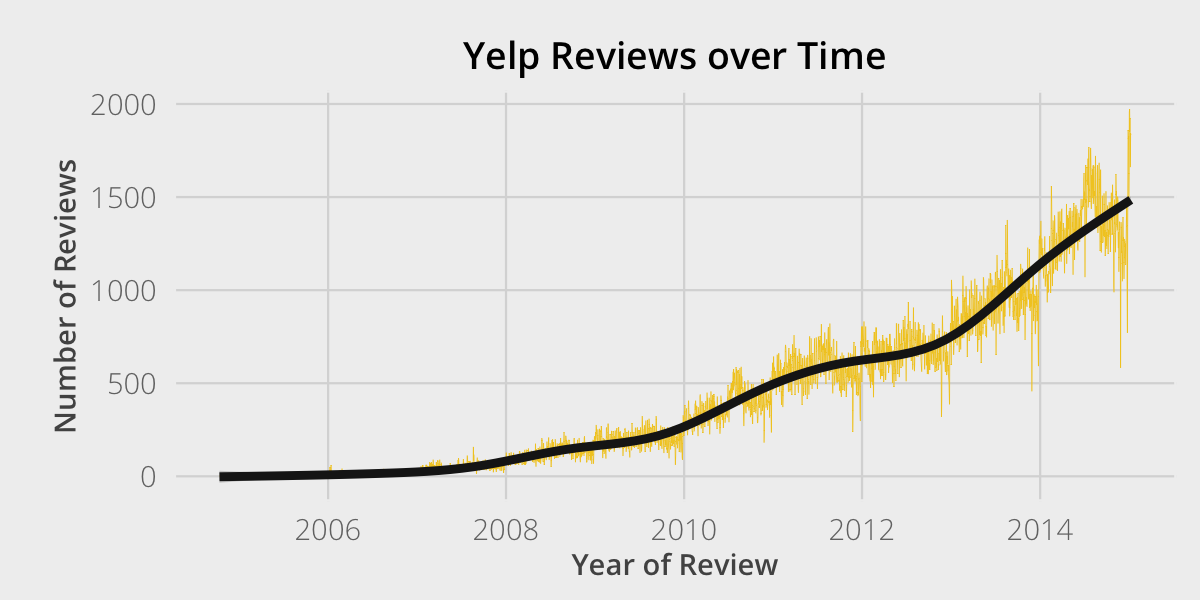

In [7]:
plot <- ggplot(ratings_daily, aes(x=date, y=count)) +
            geom_line(color="#F2CA27", size=0.1) +
            geom_smooth(color="#1A1A1A") + 
            fte_theme() + 
            labs(x="Year of Review", y="Number of Reviews", title="Yelp Reviews over Time")

options(repr.plot.height=2)

plot

### How do the individual ratings change over time? 

To account for the increased traffic on Yelp over time, we need to normalize each rating by the total ratings each day. With this, we can instead show the proportion of a given rating over time. 

Additionally, since there were significantly less reviews in 2004 and 2005, we'll filter out days where there weren't more than 50 reviews to make our analysis more robust. 

In [8]:
ratings_stars <- ratings_df %>%
    group_by(date, stars) %>%
    summarize(count = n()) %>%
    group_by(date) %>%
    mutate(norm = count / sum(count) * 100, sum = sum(count)) %>%
    filter(sum > 50)

ratings_stars$stars <- factor(ratings_stars$stars, 
                              level=1:5, 
                              label=c("1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"))

head(ratings_stars)

,date,stars,count,norm,sum
1,2006-01-13,1 Star,3,5,60
2,2006-01-13,2 Stars,3,5,60
3,2006-01-13,3 Stars,9,15,60
4,2006-01-13,4 Stars,19,31.66667,60
5,2006-01-13,5 Stars,26,43.33333,60
6,2007-01-17,1 Star,2,3.773585,53


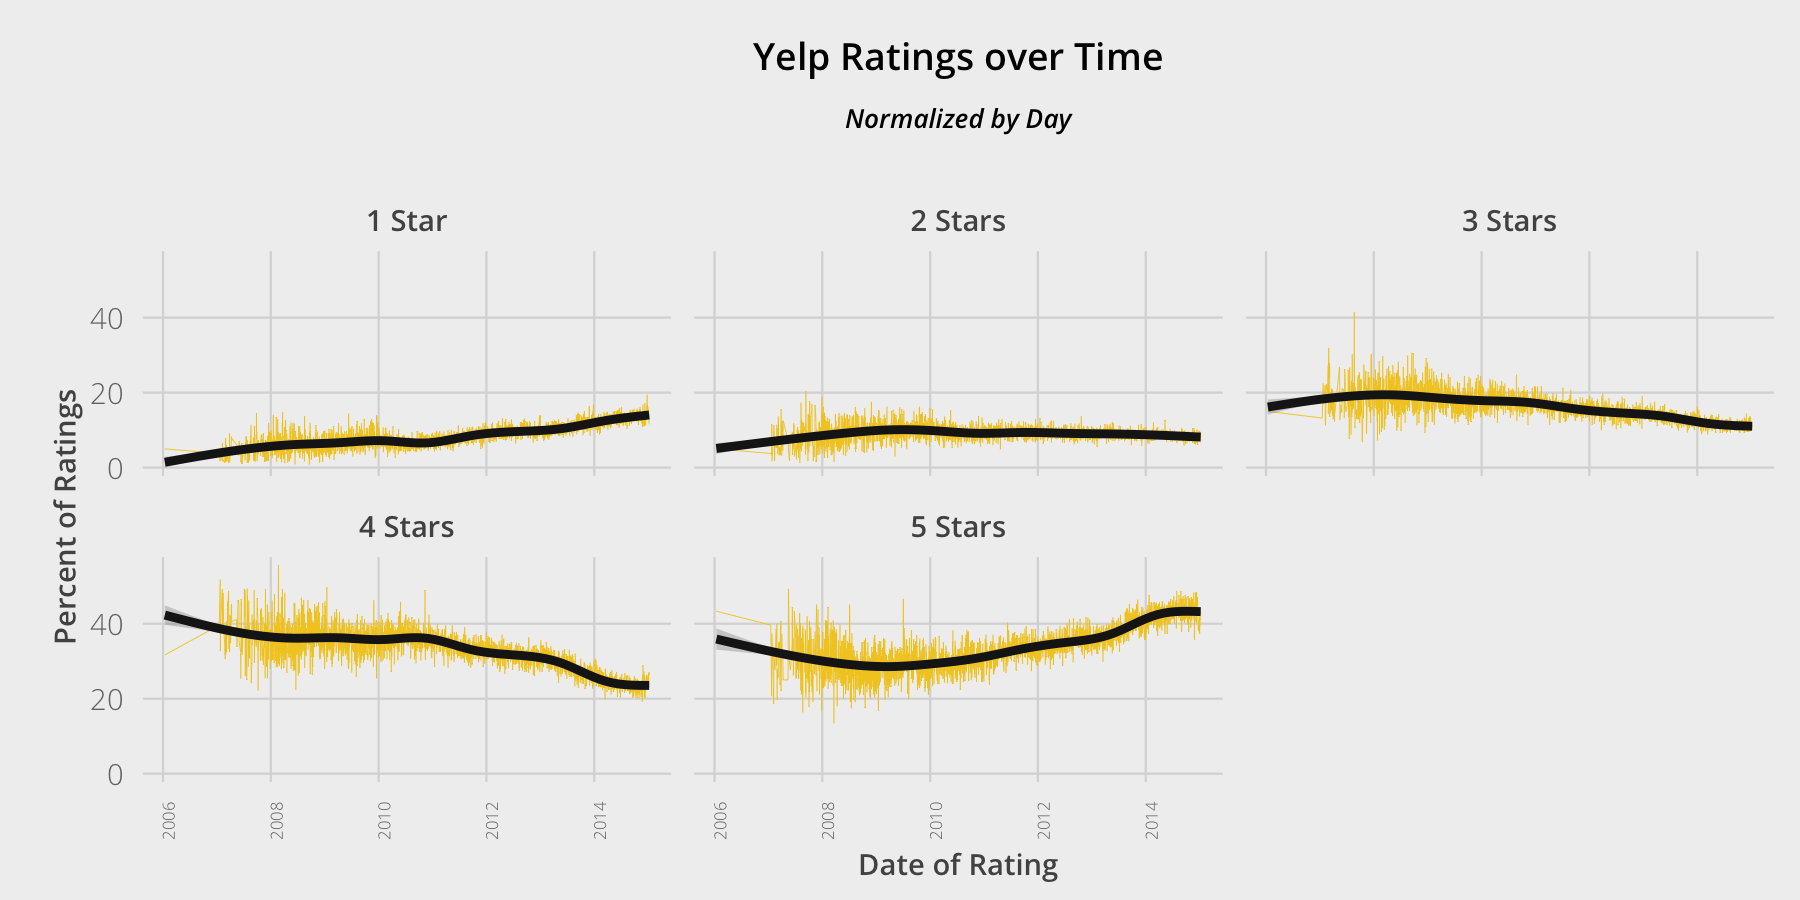

In [29]:
plot <- ggplot(ratings_stars, aes(x=date, y=norm)) + 
            geom_line(color="#F2CA27", size=0.1) +
            geom_smooth(color="#1A1A1A") +
            fte_theme() +
            theme(axis.text.x = element_text(angle=90, size=4)) + 
            labs(x="Date of Rating", y="Percent of Ratings") + 
            ggtitle(expression(atop("Yelp Ratings over Time", 
                               atop(italic("Normalized by Day"), "")))) +
            facet_wrap(~stars)

options(repr.plot.height=3)

plot

# Yelp Rating by Seasonality

In [10]:
ratings_dow <- ratings_stars %>%
    mutate(dow = weekdays(as.Date(date)),
           month = format(as.Date(date), '%B')) %>%
    group_by(dow, month) %>%
    summarize(total = sum(count))

ratings_dow$month <- factor(ratings_dow$month, levels=rev(c("January", "February", "March", "April",
                                                          "May", "June", "July", "August",
                                                          "September", "October", "November", "December")))

ratings_dow$dow <- factor(ratings_dow$dow, levels=c("Sunday", "Monday", "Tuesday", "Wednesday",
                                                  "Thursday", "Friday", "Saturday"))

head(ratings_dow)

,dow,month,total
1,Friday,April,15440
2,Friday,August,20741
3,Friday,December,16739
4,Friday,February,13621
5,Friday,January,17684
6,Friday,July,18070


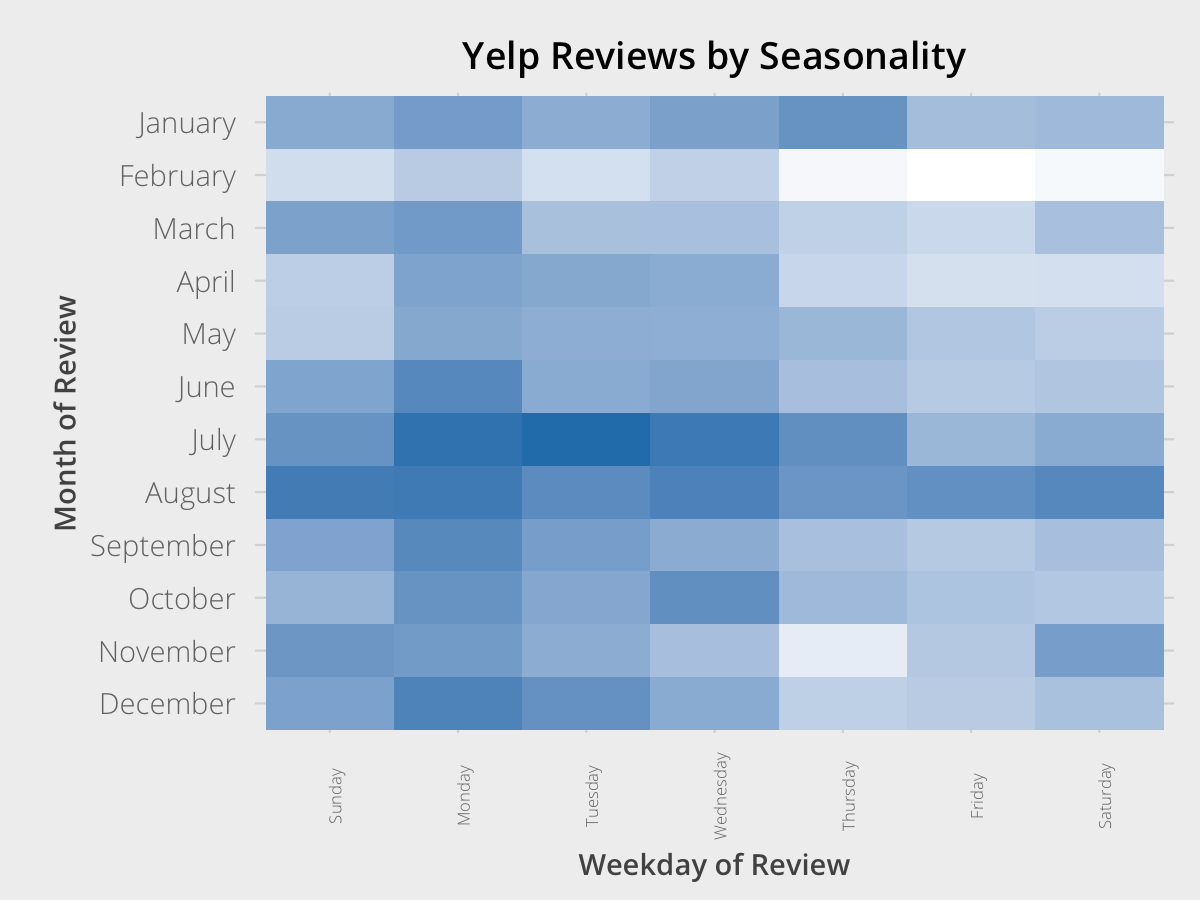

In [11]:
plot <- ggplot(ratings_dow, aes(x=dow, y=month, fill=total)) +
            geom_tile() +
            fte_theme() +
            scale_fill_gradient(low="white", high="#2980B9") +
            theme(axis.text.x=element_text(angle=90, size=4)) + 
            labs(x="Weekday of Review", y="Month of Review", title="Yelp Reviews by Seasonality")

options(repr.plot.width=4, repr.plot.height=3, tall=T)
plot

### How do the individual ratings change depending on seasonality? 

First, we need to find the percentage of each rating broken down by the day of week and month of year. 

Since the range of percentages differ for each rating, we can also index the percentages by each facet so that they will be at the same scale. 

In [12]:
ratings_dow_stars <- ratings_stars %>% 
    mutate(dow = weekdays(as.Date(date)),
           month = format(as.Date(date), '%B')) %>%
    group_by(dow, month, stars) %>% 
    summarize(total = sum(count)) %>% 
    group_by(dow, month) %>%
    mutate(percent = total / sum(total), sum = sum(total)) %>%
    group_by(stars) %>%
    mutate(norm = percent / max(percent) * 100, max = max(percent)) #%>%
    #filter(norm == 100)

ratings_dow_stars$month <- factor(ratings_dow_stars$month, levels=rev(c("January", "February", "March", "April",
                                                          "May", "June", "July", "August",
                                                          "September", "October", "November", "December")))

ratings_dow_stars$dow <- factor(ratings_dow_stars$dow, levels=c("Sunday", "Monday", "Tuesday", "Wednesday",
                                                  "Thursday", "Friday", "Saturday"))

head(ratings_dow_stars)

,dow,month,stars,total,percent,sum,norm,max
1,Friday,April,1 Star,1536,0.09948187,15440,84.43052,0.1178269
2,Friday,April,2 Stars,1408,0.09119171,15440,89.62749,0.1017452
3,Friday,April,3 Stars,2194,0.1420984,15440,90.68678,0.1566915
4,Friday,April,4 Stars,4643,0.3007124,15440,92.77289,0.3241383
5,Friday,April,5 Stars,5659,0.3665155,15440,92.08099,0.398036
6,Friday,August,1 Star,2266,0.1092522,20741,92.72263,0.1178269


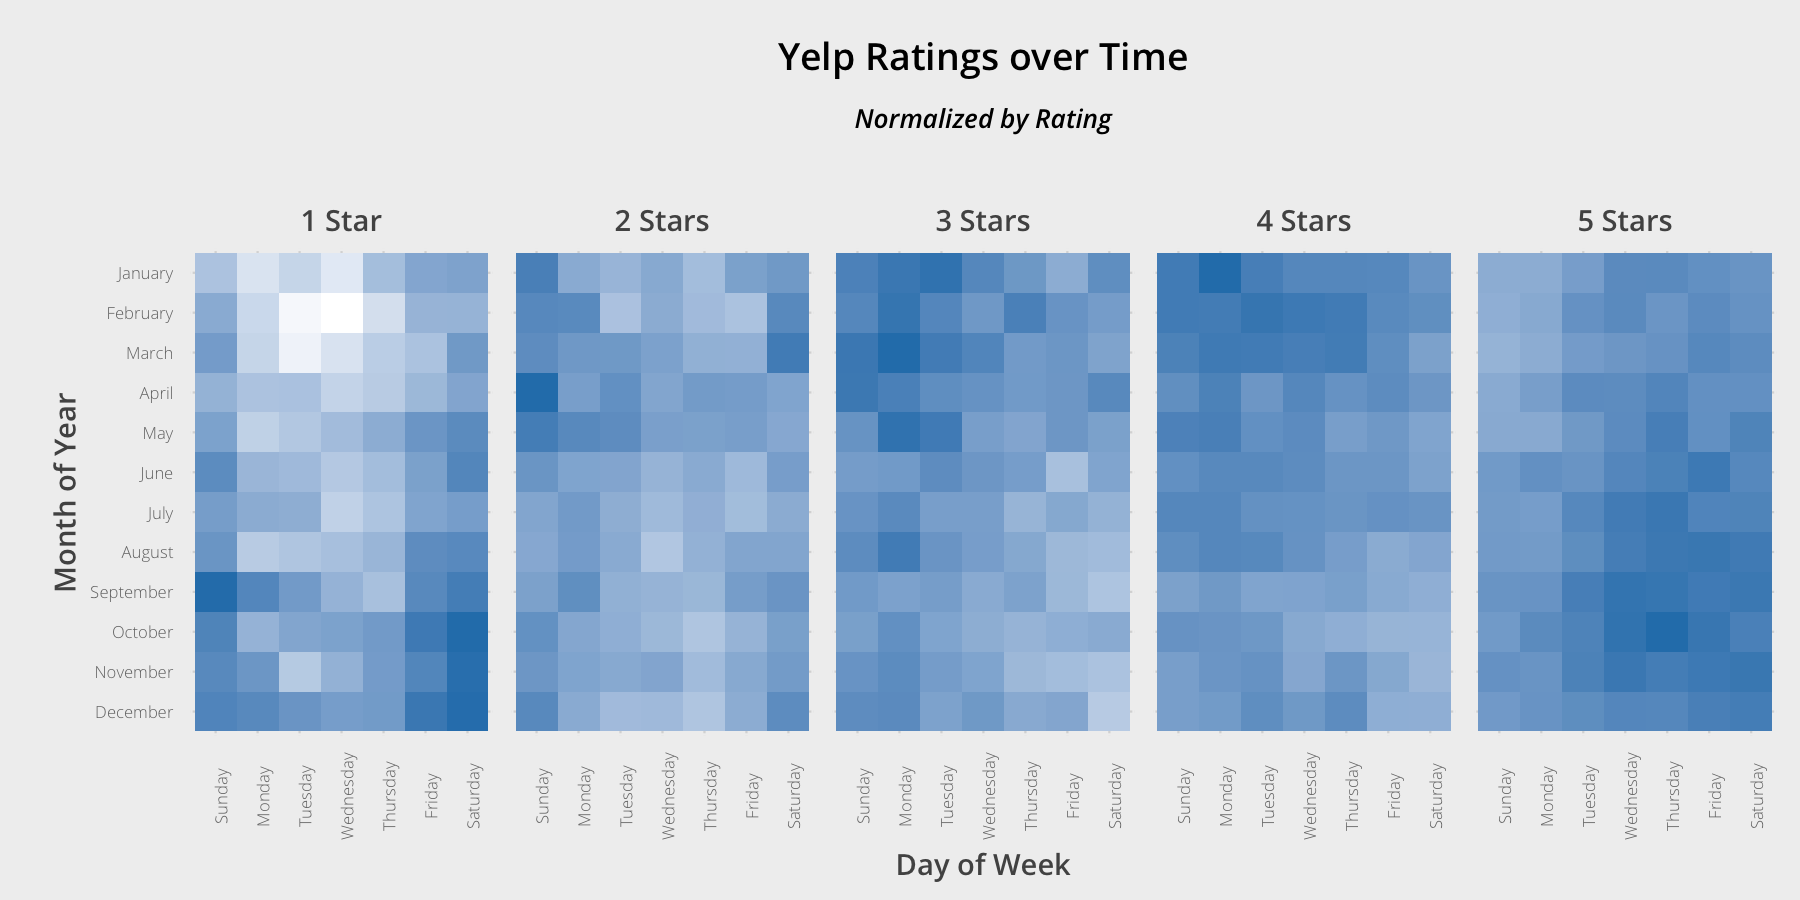

In [13]:
plot <- ggplot(ratings_dow_stars, aes(x=dow, y=month, fill=norm)) +
            geom_tile() + 
            fte_theme() + 
            theme(axis.text.x = element_text(angle=90, size=4), 
                  axis.text.y = element_text(size=4)) + 
            scale_fill_gradient(low="white", high="#2980B9") +
            labs(x="Day of Week", y="Month of Year") +
            ggtitle(expression(atop("Yelp Ratings over Time", atop(italic("Normalized by Rating"), "")))) +
            facet_wrap(~stars, nrow=1)

options(repr.plot.width=6, repr.plot.height=3, tall=T)

plot


# Yelp Reviews

Let's now start to explore the actual text in the reviews. First, how do the number of words vary between ratings?

In [14]:
names(review_df)

[1] "user_id"      "review_id"    "text"         "votes.cool"   "business_id" 
 [6] "votes.funny"  "stars"        "date"         "type"         "votes.useful"

**Do different ratings have a characteristic word count? **

For this, I'll first find the word count for each review. Similar to the heat maps, I'll also normalize by each facet, to ensure that we don't bias towards ratings that have more or less reviews. 

In [15]:
review_length <- review_df %>%
    select(which(names(review_df) %in% c("text", "business_id", "stars"))) %>%
    mutate(num_words = sapply(gregexpr("[[:alpha:]]+", text), function(x) sum(x > 0))) %>%
    arrange(num_words) %>%
    filter(num_words > 0)

In [16]:
head(review_length)

,text,business_id,stars,num_words
1,Hoofah.,wJr6kSA5dchdgOdwH6dZ2w,2,1
2,Nope!,6p9TlP2I8S4agxYMNFSDjg,1,1
3,ewwww,OZfpG8tDCcIEq8pzgZdyKw,1,1
4,Great,ZL6DNzyenFm9Kpz6uADlNg,1,1
5,A,cuuJJ9W3tYmidaLvlzvPBw,1,1
6,Fabulous!,qUeBDN0D8SC93KeAHhiL-g,5,1


In [17]:
review_length_stars <- review_length %>%
    group_by(stars, num_words) %>%
    summarize(count=n()) %>%
    group_by(stars) %>%
    mutate(norm = count/max(count) * 100, max = max(count)) 

review_length_stars$stars <- factor(review_length_stars$stars, 
                                       level=1:5,
                                       labels=c("1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"))

head(review_length_stars)

,stars,num_words,count,norm,max
1,1 Star,1,260,27.92696,931
2,1 Star,2,149,16.0043,931
3,1 Star,3,245,26.31579,931
4,1 Star,4,266,28.57143,931
5,1 Star,5,256,27.49731,931
6,1 Star,6,290,31.1493,931


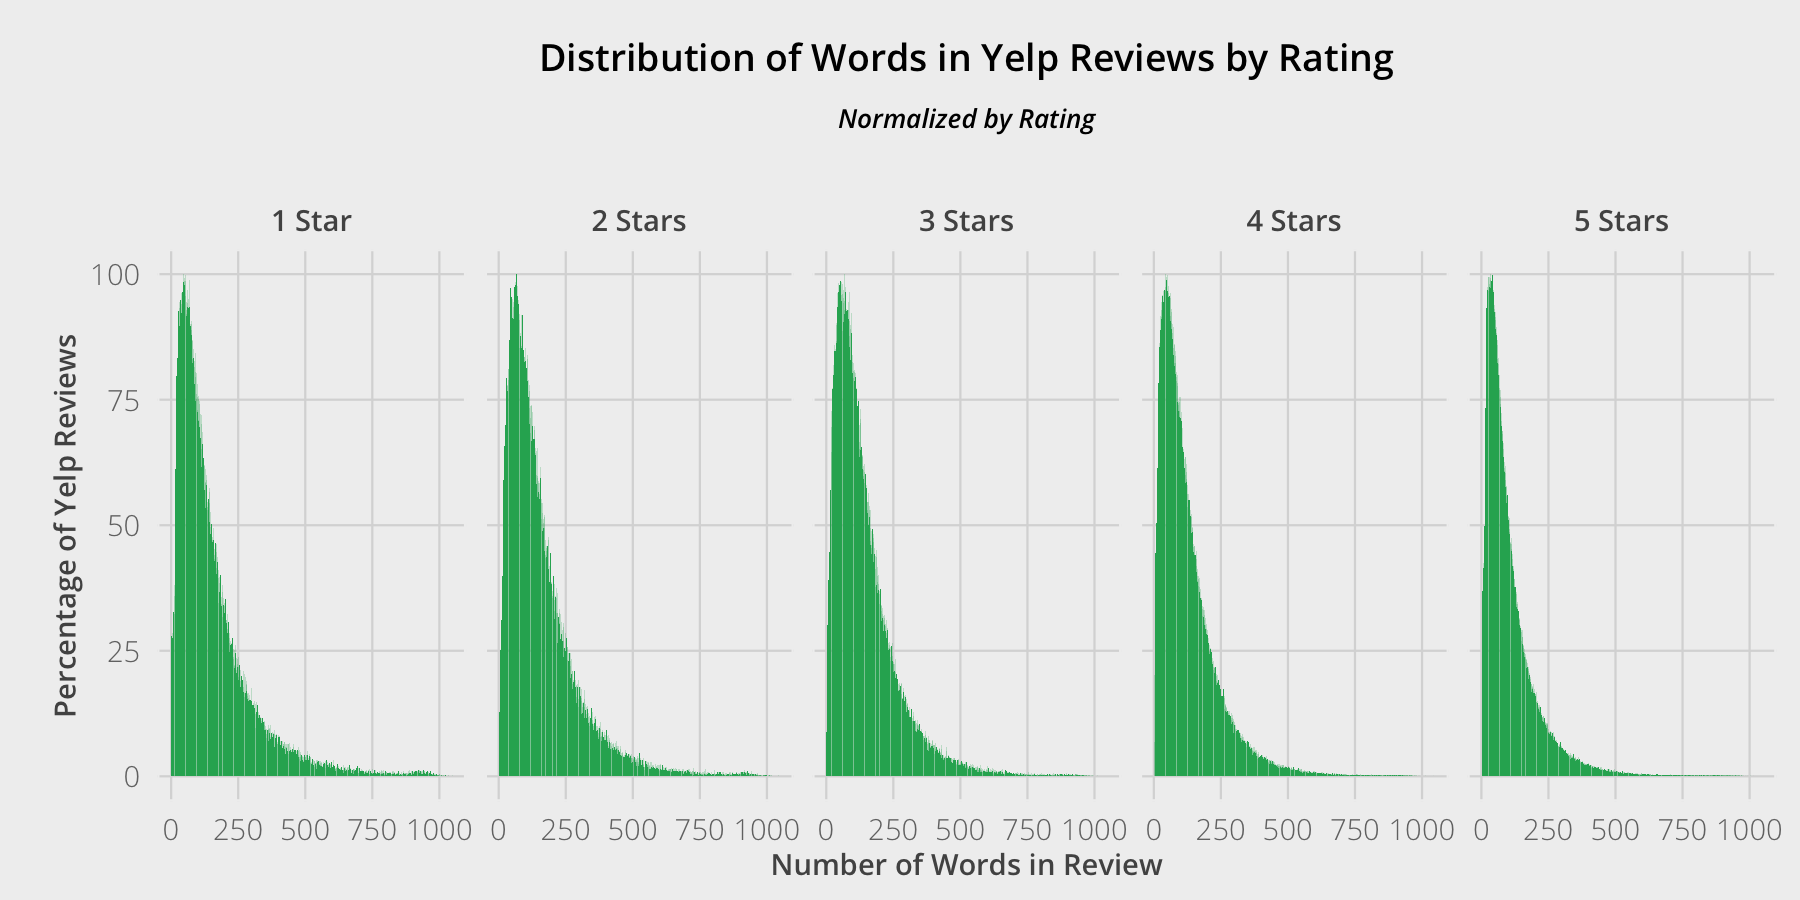

In [18]:
plot <- ggplot(review_length_stars, aes(x=num_words, y=norm)) + 
            geom_bar(stat="identity", fill="#27AE60", position="dodge") + 
             #geom_smooth(color="#1A1A1A", method="loess") +
            fte_theme() + 
            labs(x="Number of Words in Review", y="Percentage of Yelp Reviews") + 
            ggtitle(expression(atop("Distribution of Words in Yelp Reviews by Rating", 
                                    atop(italic("Normalized by Rating"), "")))) +
            facet_wrap(~stars, nrow=1)

options(repr.plot.width=6, repr.plot.height=3, tall=T)

plot

Though there are slight differences amongst the distributions, the overall pattern looks similar between each rating. 

### What are key phrases in different ratings?

Next, let's look at the most frequent phrases in 1-star vs. 5-star ratings.

In [19]:
df_one_star <- review_df %>% 
                    filter(stars == 1)

df_five_stars <- review_df %>% 
                    filter(stars == 5) 

In [20]:
BigramTokenizer <- function(x) {
    unlist(lapply(ngrams(words(x), 2), paste, collapse = " "), use.names = FALSE)}

In [21]:
create_dtm <- function(x) {
    text <- paste(x$text, collapse = " ")
    
    # removing stop words and lowering text 
    text <- unlist(strsplit(tolower(text), " "))
    text <- paste(unlist(text[which(!(text %in% stopwords("english")))]), collapse= " ")
    
    source <- VectorSource(text)
    corpus <- Corpus(source)
    #corpus <- tm_map(corpus, content_transformer(tolower))
    corpus <- tm_map(corpus, removePunctuation)
    corpus <- tm_map(corpus, removeNumbers)
    corpus <- tm_map(corpus, stripWhitespace)
    dtm <- TermDocumentMatrix(corpus, control = list(tokenize = BigramTokenizer))
    return(dtm)
}

In [22]:
find_freq <- function(x) { 
    df <- as.data.frame(as.matrix(x))
    df$"phrase" <- rownames(df)
    rownames(df) <- 1:length(rownames(df))
    names(df) <- c("frequency", "phrase")
    freq <- arrange(df, desc(frequency))
    return(freq)
}

In [23]:
one_star_phrases <- find_freq(create_dtm(df_one_star))

In [24]:
five_star_phrases <- find_freq(create_dtm(df_five_stars))

In [25]:
head(one_star_phrases, n=50)

,frequency,phrase
1,17894,customer service
2,12280,will never
3,9790,go back
4,6478,first time
5,6190,come back
6,5813,even though
7,5584,front desk
8,5524,never go
9,5043,tasted like
10,5040,las vegas


In [26]:
head(five_star_phrases, n=50)

,frequency,phrase
1,28678,highly recommend
2,25829,las vegas
3,24176,love place
4,22364,first time
5,21355,will definitely
6,21001,go back
7,19656,great service
8,19350,customer service
9,18810,great food
10,17871,great place


In [27]:
one_star_short <- one_star_phrases[1:500, ]
five_star_short <- five_star_phrases[1:500, ]
write.csv(one_star_short, "Yelp_onestar.csv")
write.csv(five_star_short, "Yelp_fivestar.csv")